# RNN - LSTM, GRU, Bidrectional Layers

There are 3 models below to generate text.

1. 2 LSTM layers
2. 2 GRU layers
3. 2 Bidirectional GRU layers

# Setup


In [ ]:
# @title Import packages
import numpy as np
import re
from pathlib import Path
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Input, Embedding, Dropout
from tensorflow.keras.layers import Permute, Flatten, Activation, RepeatVector, Multiply, Lambda
from tensorflow.keras.layers import Attention

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

In [ ]:
# @title Mount GDrive
train_model = True

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Unit of token
token_type = 'word'

In [ ]:
# @title Download Dataset
!mkdir -p /content/aesop
!wget https://www.gutenberg.org/cache/epub/11339/pg11339.txt -O /content/aesop/data.txt

--2024-07-19 15:00:41--  https://www.gutenberg.org/cache/epub/11339/pg11339.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241922 (236K) [text/plain]
Saving to: ‘/content/aesop/data.txt’

/content/aesop/data 100%[===================>] 236.25K  --.-KB/s    in 0.06s   

2024-07-19 15:00:42 (4.01 MB/s) - ‘/content/aesop/data.txt’ saved [241922/241922]



# Dataset

## Normalization of dataset

In [ ]:
# load the text file and extract the main stories

seq_length = 20

filename = "/content/aesop/data.txt"

with open(filename, encoding='utf-8-sig') as f:
    text = f.read()


#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]
len(text)

197444

In [ ]:
# normalize the text

start_story = '| ' * seq_length
text = start_story + text # add a prefix indicating a beginning of stories

text = text.lower()
text = text.replace('\n\n\n\n\n', start_story) # assign identifiers to chapter breaks
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text) # extract symbols
text = re.sub('\s{2,}', ' ', text)
len(text)

213716

In [ ]:
text

' | | | | | | | | | | | | | | | | | | | | the fox and the grapes . a hungry fox saw some fine bunches of grapes hanging from a vine that was trained along a high trellis , and did his best to reach them by jumping as high as he could into the air . but it was all in vain , for they were just out of reach : so he gave up trying , and walked away with an air of dignity and unconcern , remarking , " i thought those grapes were ripe , but i see now they are quite sour . " | | | | | | | | | | | | | | | | | | | | the goose that laid the golden eggs . a man and his wife had the good fortune to possess a goose which laid a golden egg every day . lucky though they were , they soon began to think they were not getting rich fast enough , and , imagining the bird must be made of gold inside , they decided to kill it in order to secure the whole store of precious metal at once . but when they cut it open they found it was just like any other goose . thus , they neither got rich all at once , as the

## Make vocabluary and convert words to tokens

In [ ]:
if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    # char_level: if True, every character will be treated as a token.
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)

tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1 # add 1 because the index number starts from 1, not 0
token_list = tokenizer.texts_to_sequences([text])[0]

In [ ]:
total_words

4169

In [ ]:
print(tokenizer.word_index)
print(token_list[:500])

{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 6, 'to': 7, '"': 8, 'of': 9, 'he': 10, 'his': 11, 'was': 12, 'you': 13, 'in': 14, 'him': 15, 'it': 16, 'for': 17, 'i': 18, 'but': 19, 'that': 20, 'with': 21, 'said': 22, 'they': 23, 'at': 24, 'as': 25, 'when': 26, 'on': 27, 'so': 28, 'by': 29, ':': 30, 'one': 31, 'had': 32, ';': 33, 'be': 34, 'them': 35, 'up': 36, 'all': 37, 'who': 38, '-': 39, 'her': 40, 'my': 41, 'is': 42, 'out': 43, 'me': 44, 'not': 45, 'your': 46, 'were': 47, 'which': 48, 'have': 49, 'their': 50, 'no': 51, 'lion': 52, 'she': 53, 'if': 54, 'into': 55, 'fox': 56, 'an': 57, 'what': 58, 'ass': 59, '!': 60, 'time': 61, 'from': 62, 'are': 63, 'came': 64, '?': 65, 'man': 66, 'do': 67, 'about': 68, 'there': 69, 'wolf': 70, 'then': 71, 'upon': 72, 'himself': 73, 'this': 74, 'day': 75, 'would': 76, 'some': 77, 'once': 78, 'will': 79, 'very': 80, 'went': 81, 'well': 82, 'than': 83, 'down': 84, 'replied': 85, 'got': 86, 'off': 87, 'could': 88, 'away': 89, 'see': 90, 'good': 91,

## Make training data

In [ ]:
# X: each instance has tokens whose length is seq_length
# y: each label is a token coming to next and encoded as one-hot
def generate_sequences(token_list, step):
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length]) # store seq_length (20) tokens
        y.append(token_list[i + seq_length]) # store a token coming next

    # the output of the model is a probability distribution of the vocabularies
    # that appears next in the sequence data, so we OneHot encode the correct label
    # to compute the loss with 'categorical_crossentropy'
    y = to_categorical(y, num_classes = total_words)

    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")

    return X, y, num_seq

step = 1
seq_length = 20

X, y, num_seq = generate_sequences(token_list, step)

X = np.array(X)
y = np.array(y)
X.shape, y.shape

Number of sequences: 50416 



((50416, 20), (50416, 4169))

In [ ]:
X[100]

array([  18,  144,  260,  940,   47, 1177,    2,   19,   18,   90,  115,
         23,   63,  360, 2229,    5,    8,    1,    1,    1])

In [ ]:
y[100]

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

# LSTM model

The embedding layer is essentially a lookup table for integer tokens, converting each token into a vector of length embedding_size.

Therefore, the number of weights trained in this layer is equal to the vocabulary size multiplied by embedding_size.

```
| Token |            Embedding (100dim)           |
|-------+-----------+-------+-----+-------+-------|
|     1 |     -0.13 |  0.45 | ... |  0.13 | -0.04 |
|     2 |      0.22 |  0.56 | ... |  0.24 | -0.63 |
|   ... |       ... |   ... | ... |   ... |   ... |
|  4168 |      0.16 | -0.70 | ... | -0.35 |  1.02 |
|  4169 |     -0.98 | -0.45 | ... | -0.15 | -0.52 |
```


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         416900    
                                                                 
 lstm (LSTM)                 (None, None, 256)         365568    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 4169)              1071433   
                                                                 
Total params: 2379213 (9.08 MB)
Trainable params: 2379213 (9.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


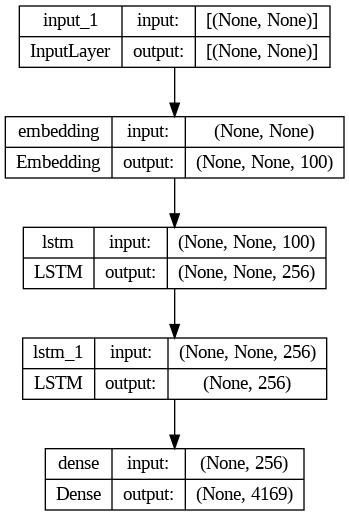

In [ ]:
# @title Define LSTM

dpath = Path('/content/drive/MyDrive/Colab Notebooks')
dpath_model = dpath / 'saved_models/lstm/aesop_no_dropout_100'

if not train_model:
    # model = load_model('./saved_models/lstm_aesop_1.h5')
    # model = load_model('./saved_models/aesop_dropout_100.h5')
    model = load_model(dpath_model)
else:

    n_units = 256 # node number of LSTM cell
    embedding_size = 100

    text_in = Input(shape = (None,))
    embedding = Embedding(total_words, embedding_size) # lookup table total_words x embedding_size
    x = embedding(text_in)
    x = LSTM(n_units, return_sequences = True)(x) # output all of hidden vectors to next LSTM layer
    x = LSTM(n_units)(x)
    # x = Dropout(0.2)(x)
    text_out = Dense(total_words, activation = 'softmax')(x) # probability distribution of vocablaries

    model = Model(text_in, text_out)

    opti = RMSprop(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opti)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# @title Helper function to generate a text with a temperature

def sample_with_temp(preds, temperature=1.0):
    # sample an index from a probability distribuiton by weighting with temperature
    preds = np.asarray(preds).astype('float64') # (4169,)
    preds = preds ** (1 / temperature)
    preds = preds / np.sum(preds)
    return np.random.choice(len(preds), p=preds)

def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    seed_text = start_story + seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))

        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)

        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]

        if output_word == "|":
            break

        if token_type == 'word':
            output_text += output_word + ' '
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '

    return output_text

In [ ]:
# @title Train LSTM

%%time

def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 50

    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))

if train_model:
    epochs =  200 # 1000
    batch_size = 64 # 32
    num_batches = int(len(X) / batch_size)
    callback = LambdaCallback(on_epoch_end=on_epoch_end)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)

Epoch 1/200
788/788 [==============================] - ETA: 0s - loss: 5.3301Temp 0.2

Temp 0.33

Temp 0.5
the lion . the a own . . the . and the of to the lion of the savoury , the her who a her . and his wolf , and was . " the men . he fox . " the caught , and the lion and the him 
Temp 1.0

788/788 [==============================] - 26s 27ms/step - loss: 5.3301
Epoch 2/200
788/788 [==============================] - ETA: 0s - loss: 4.8692Temp 0.2
the fox and the fox . a fox . a fox , and the fox , and the fox , and the fox , and the fox , and the man , and the fox , and the fox , and the lion , and the lion of the lion 
Temp 0.33
the man and the . and the fox . the ass , and the lion , and the fox , and the the lion , and the lion , and the lion , the lion , he the ass , the fox , and was had the ass , and 
Temp 0.5
the man and the man . a fox man a lion , and the ass , and was his ass of the ass , and the cat , and it a ass , and the fox , and the lion , at the lion , and the have ,

In [ ]:
seed_text = "the frog and the snake . the frog went to "
gen_words = 50 # 500
temp = 5.0

print (generate_text(seed_text, gen_words, model, seq_length, temp))

the frog and the snake . the frog went to snake seaside sirrah life loudly patting fright sprouted spread plunged ungainly sank greedily prove dropped a brazen rays trod swan should wrought cocked sloth ; shame about hesitated prayers cold don't lasted master departed carried ? perjury sea stolen leave addressed saved shared grasshopper heart's again 'humph overflowing ; silent 


## Export model

In [ ]:
dpath_model = dpath / 'saved_models/lstm/aesop_no_dropout_100'
model.save(dpath_model)

In [ ]:
to_categorical(data, num_classes=10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# GRU model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         416900    
                                                                 
 gru (GRU)                   (None, None, 256)         274944    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_1 (Dense)             (None, 4169)              1071433   
                                                                 
Total params: 2158029 (8.23 MB)
Trainable params: 2158029 (8.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


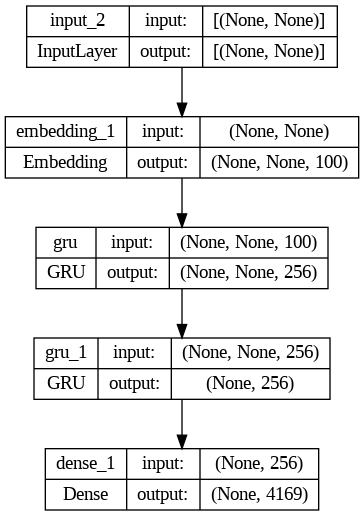

In [ ]:
# @title Define GRU

n_units = 256 # node number of GRU cell
embedding_size = 100

text_in = Input(shape = (None,))
embedding = Embedding(total_words, embedding_size) # lookup table total_words x embedding_size
x = embedding(text_in)
x = GRU(n_units, return_sequences = True)(x)
x = GRU(n_units)(x)
# x = Dropout(0.2)(x)
text_out = Dense(total_words, activation = 'softmax')(x) # probability distribution of vocablaries

model = Model(text_in, text_out)

opti = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opti)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# @title Train GRU
epochs =  30 # 200 # 1000
batch_size = 64 # 32
num_batches = int(len(X) / batch_size)
callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)

Epoch 1/30
788/788 [==============================] - ETA: 0s - loss: 5.1337Temp 0.2

Temp 0.33

Temp 0.5

Temp 1.0
the observing brought the dog young ailing are darted to headed . and one cries rebuked the dearly worried : . if your he rather swallow down in the policy admitted for it , whiles , he , and one have hares about call , when following combing well he 
788/788 [==============================] - 19s 20ms/step - loss: 5.1337
Epoch 2/30
788/788 [==============================] - ETA: 0s - loss: 4.6967Temp 0.2

Temp 0.33

Temp 0.5
the ass and the dog . a dog , a lion was a violent to a an for of the lion , and was the dog to the fox , and the ass of the he of the little , , and was in the was of the ass , 
Temp 1.0

788/788 [==============================] - 12s 15ms/step - loss: 4.6967
Epoch 3/30
788/788 [==============================] - ETA: 0s - loss: 4.5041Temp 0.2
the fox and the fox . a man was a man were a man , and , when he was a good of the good of him , and , " i h

In [ ]:
dpath_model = dpath / 'saved_models/gru/aesop_no_dropout_100'
model.save(dpath_model)

# Bidirectional GRU

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         416900    
                                                                 
 bidirectional (Bidirection  (None, None, 512)         549888    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1182720   
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 4169)              2138697   
                                                                 
Total params: 4288205 (16.36 MB)
Trainable params: 4288205 

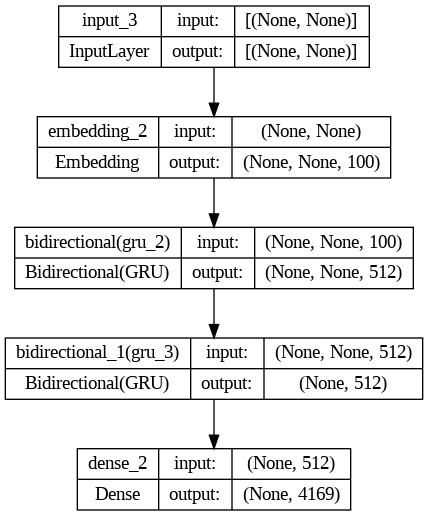

In [ ]:
# @title Define Bidrectional GRU
n_units = 256 # node number of GRU cell
embedding_size = 100

text_in = Input(shape = (None,))
embedding = Embedding(total_words, embedding_size) # lookup table total_words x embedding_size
x = embedding(text_in)
x = Bidirectional(GRU(n_units, return_sequences=True))(x)
x = Bidirectional(GRU(n_units))(x)
# x = Dropout(0.2)(x)
text_out = Dense(total_words, activation = 'softmax')(x) # probability distribution of vocablury

model = Model(text_in, text_out)

opti = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opti)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# @title Train Bidirectional GRU

epochs =  30 # 200 # 1000
batch_size = 64 # 32
num_batches = int(len(X) / batch_size)
callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)

Epoch 1/30
788/788 [==============================] - ETA: 0s - loss: 5.0879Temp 0.2
the ass and the the . . a was was a ass , and was a man , and was his fox , and was a man , and , " he was , " he , " " i you you you you you you you the ass , 
Temp 0.33
the ass and the the . . a was man in the ass , and was a ass , and , he was his man , " " the very man , " " he you you you a lion , he he be be your very time , and 
Temp 0.5
the ass and the dog . a was was a man , and , a man into was a dog , and was was a ass , " he said , and he , " he , " " you i you you you the way . " 
Temp 1.0
the said and the dogs . a signs on a fitting into two hope a side , caught he asked and off roared . " swan of , i was way , " are i we had help some day , when birds busied choose all you entangled down will 
788/788 [==============================] - 36s 38ms/step - loss: 5.0879
Epoch 2/30
788/788 [==============================] - ETA: 0s - loss: 4.6247Temp 0.2
the man and the man . a man was a man , 